#Introduction

This Colab Notebook is the work and submission of Zain Momin, part of Group 1 for the CS 3793.001 Artificial Intelligence Group Projects of the Spring 2022 semester.

This NLP model will leverage a Count Vectorizer to vectorizer the text from the Kaggle data set. Once the data is vectorized the final N-Gram model will classify wach article assigning it a value of fake news or not fake news.


#IMPORTED LIBRARIES





In [58]:
#Import libraries and connect to google drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import string

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

from google.colab import drive
drive.mount('/content/drive')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Import model specific resources or libraries

In [4]:
#The basepath is the same as what it is in the class assignments for simplicity
basePath = "/content/drive/My Drive/Colab Notebooks/Artificial Intelligence/Data/"

##Data files used, and how the files are structured

The Dataset used for this Machine Learning Model is a Kaggle Dataset consisting of Fake and Real news articles, formatted in 'csv' files. 

The link to the dataset is: https://www.kaggle.com/c/fake-news/data?select=test.csv

Downloading the dataset will give you two file "train.csv" and "test.csv". For simplicities sake, the contents of both datasets will get combined into one larger data set in which the Model will be trained and tested with.

As shown above, during the making of this Notebook the train and test csv files where loaded into the base path directory that was usued for all class assignment. This was done for consistancy with the class and for simplicity.

In [5]:
# Data file name variables
train = basePath + "train.csv"
test = basePath + "test.csv"

The CSV files come foramtted with 5 total columns. The columns are 'id', 'title', 'author', 'text', and 'label'. 

    ID: The designation number of the article in the file
    Title: Title of the associated news article
    Author: Person who wrote the News article
    Text: All words of the news article 
    Label: Designation of whether the news article is reliable or unreliable. O means unreliable, 1 means reliable. (These essentially refer to Fake or Real)

'Train.csv' has 20799 rows in it by default. 'Test.csv' has 25999 rows in it by default.

##Formatting the Data

In order to use data of the files, it has to be prepared and formatted in a certain manner. This invovles scrubbing the id, title, and author columns from the both datasets. Also, any rows with NAN values need to be removed entirely as they are unsuitable. 

The next step involves combining the contents of the train and test datasets into one final dataset that will be used for the Machine Learning portion of the notebook.

In [28]:
# 0 = reliable, 1 = unreliable

# Read the training file
data_train = pd.read_csv( train )
data_train = data_train.drop(['id','author','title'], 1)
data_train.dropna( inplace=True) 
data_train.reset_index(inplace = True, drop = True)
print( data_train.shape )

# Read the testing data file
data_test  = pd.read_csv( test )
data_test = data_test.drop(['id','author','title'], 1)
data_test.dropna( inplace=True) 
data_test = data_test.loc[ :, :'label']
data_test.reset_index(inplace = True, drop = True)
print( data_test.shape )

# Combine both train and test datasets into a final dataset which is used later on
dataset = pd.concat( [data_train, data_test], ignore_index=True)
print( dataset.shape)
dataset.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


(20800, 2)
(5200, 0)
(26000, 2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if sys.path[0] == '':


,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1.0
1,Ever get the feeling your life circles the rou...,0.0
2,"Why the Truth Might Get You Fired October 29, ...",1.0
3,Videos 15 Civilians Killed In Single US Airstr...,1.0
4,Print \nAn Iranian woman has been sentenced to...,1.0


#Check the final dataset to make sure it is valid for usage

The final dataset that will be used has 2 columns of "text" and "label". There are about 20762 total rows in the dataset, with about a 50:50 percent split between Fake and Real articles in the set. These statistics are shown below. 

0.0    10387
1.0    10374
Name: label, dtype: int64


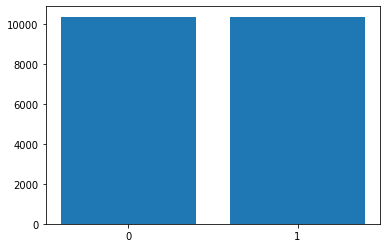

In [26]:
#graph the total number of fake and real articles in the final dataset
real_or_not = dataset.label.value_counts()
print( real_or_not )

plt.figure()
plt.bar( ['0','1'], real_or_not )
plt.show()

The dataset is lastly checked so that no NaN values are present. The ouptut of the next cell is empty because there are no NaN values present.

In [31]:
dataset.dropna(inplace=True)
dataset[dataset.isnull().any(axis=1)]

,text,label


##Supervised Machine Learning 

From this point on is where the actual Machine Learning and predictions of the Notebook will occur.

The next cell shows a helpful function to display the results of the machine learning in a discenrable manner, taken from this source.



In [32]:
#A helpful function pulled from a website (credited at the end of this Notebook) that will print out the results of the Models processing in a concise and understandable manner.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                  horizontalalignment="center",
                  color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Split the dataset into testing and training
The next cell shows the dataset being partitioned into training, and testing sets ( 80% for training, 20% for testing ) that will be used for the Model.

In [50]:
# clean the text
# removed cleaning used in N-Gram models listed from resources over N-Gram Analysis below in links
def clean_text(text):

  # go all lower case
  text = text.lower()

  #remove punctuation
  table = str.maketrans('', '', string.punctuation)
  text = text.translate(table)
  
  # remove stemming words 
  tokens = word_tokenize(text)
  porter = PorterStemmer()
  stemmed_words = [porter.stem(word) for word in tokens]
  words = [w for w in stemmed_words if not w in stopwords.words('english')]

  text = ' '.join(words)

  return text

dataset.text = [clean_text(t) for t in dataset.text]

y = dataset['label']

xtrain, xtest, ytrain, ytest = train_test_split( dataset['text'], y, test_size=0.2, random_state=7)

# N-Gram Model
This Model will utilize the Count Vectorizer to determine the range of words for n-gram and vectorize the data and transform it for training and then later testing. Leverage the K-Neighbor Classifier to predict each article

In [68]:


v1 = CountVectorizer(max_features= 1000, ngram_range=(1, 1))
v2 = CountVectorizer(max_features= 1000, ngram_range=(2, 2))
v3 = CountVectorizer(max_features= 1000, ngram_range=(3, 3))
v5 = CountVectorizer(max_features= 1000, ngram_range=(5, 5))

# Vectorize 
train_v1 = v1.fit_transform(xtrain)
test_v1 = v1.fit_transform(xtest)
KNN_1 = KNeighborsClassifier(n_neighbors=1, algorithm='brute')
KNN_1.fit(train_v1, ytrain)
y1_pred= KNN_1.predict(test_v1)

train_v2 = v2.fit_transform(xtrain)
test_v2 = v2.fit_transform(xtest)
KNN_2 = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
KNN_2.fit(train_v2, ytrain)
y2_pred= KNN_2.predict(test_v2)

train_v3 = v3.fit_transform(xtrain)
test_v3 = v3.fit_transform(xtest)
KNN_3 = KNeighborsClassifier(n_neighbors=3, algorithm='brute')
KNN_3.fit(train_v3, ytrain)
y3_pred = KNN_3.predict(test_v3)

train_v5 = v5.fit_transform(xtrain)
test_v5 = v5.fit_transform(xtest)
KNN_5 = KNeighborsClassifier(n_neighbors=5, algorithm='brute')
KNN_5.fit(train_v5, ytrain)
y5_pred = KNN_5.predict(test_v5)



#Model Results and Conclusions
As n increases the accuracy begins to fall in it's ability to classify the Fake News and Real News accuarelty 

In [76]:
score1 = accuracy_score(ytest,y1_pred)
print("N-Gram 1: Accuracy: %0.3f"%score1)


score2 = accuracy_score(ytest,y2_pred)
print("N-Gram 2: Accuracy: %0.3f"%score2)

score3 = accuracy_score(ytest,y3_pred)
print("N-Gram 3: Accuracy: %0.3f"%score3)


score5 = accuracy_score(ytest,y5_pred)
print("N-Gram 5: Accuracy: %0.3f"%score5)


N-Gram 1: Accuracy: 0.686
N-Gram 2: Accuracy: 0.617
N-Gram 3: Accuracy: 0.574
N-Gram 5: Accuracy: 0.503


Unigram Highest Accuracy: 0.686
Confusion matrix, without normalization


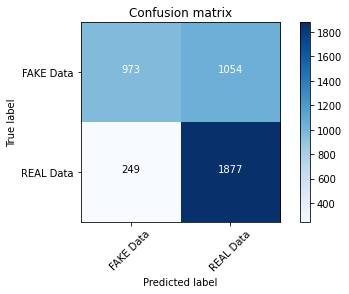

In [77]:

print("Unigram Highest Accuracy: %0.3f"%score1)
cm1 = confusion_matrix(ytest,y1_pred)
plot_confusion_matrix(cm1,classes = ['FAKE Data','REAL Data'])

#TODO: What I learned

Sources and References used:

https://iopscience.iop.org/article/10.1088/1742-6596/2007/1/012047/pdf

https://www.kaggle.com/c/fake-news/data?select=test.csv


https://medium.com/mlearning-ai/nlp-detecting-fake-news-on-social-media-aa53ff74f2ff#d7e7

https://medium.com/analytics-vidhya/fake-news-detection-using-nlp-techniques-c2dc4be05f99

https://towardsdatascience.com/detecting-fake-political-news-online-a571745f73dd

https://www.researchgate.net/publication/320300831_Detection_of_Online_Fake_News_Using_N-Gram_Analysis_and_Machine_Learning_Techniques